In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from matplotlib import pyplot as plt 
import sklearn
from sklearn.model_selection import train_test_split

## IMPORT & EXPLORE

#### FUNCTIONS

In [4]:
def generate_augmented_images(images, labels, augmentations_per_image=3):
    augmented_images = []
    augmented_labels = []

    for img, lbl in zip(images, labels):
        for _ in range(augmentations_per_image):
            # Apply random augmentations
            aug_img = tf.image.random_flip_left_right(img)
            aug_img = tf.image.random_flip_up_down(aug_img)
            aug_img = tf.image.rot90(aug_img, k=np.random.randint(4))
            aug_img = tf.image.random_brightness(aug_img, max_delta=0.1)
            aug_img = tf.image.random_contrast(aug_img, lower=0.8, upper=1.2)

            # Append new augmented image and corresponding label
            augmented_images.append(aug_img.numpy())  # Convert to NumPy for consistency
            augmented_labels.append(lbl)

    return np.array(augmented_images), np.array(augmented_labels)

In [5]:
def display_examples(images, labels, num_examples=5):
    plt.figure(figsize=(10, 10))
    
    for i in range(num_examples):
        ax = plt.subplot(1, num_examples, i + 1)
        ax.imshow(images[i])  # Display the image
        ax.set_title(f"Label: {labels[i]}")  # Display the label
        ax.axis("off")  # Hide axes
    
    plt.show()

#### IMAGES

In [6]:
lung_xray_scans = np.load(r"C:\Users\User\Desktop\LungXrayCT-Disease-Detection(TB MODEL)\data\arrays\tuberculosis_detection.npz")['images']
lung_xray_scans_labels = np.load(r"C:\Users\User\Desktop\LungXrayCT-Disease-Detection(TB MODEL)\data\arrays\tuberculosis_detection.npz")['labels']

## CLEAN & PREPARE

#### PREPARE DATA FOR MODEL BUILDING

In [7]:
lung_xray_scans , lung_xray_scans_labels = generate_augmented_images(images = lung_xray_scans,
                                                                     labels = lung_xray_scans_labels,
                                                                     augmentations_per_image = 2)

In [9]:
lung_xray_scans.shape

(8400, 224, 224, 1)

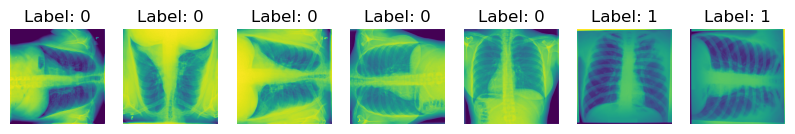

In [16]:
display_examples(images = lung_xray_scans[45:],
                 labels = lung_xray_scans_labels[45:],
                 num_examples=7)

In [23]:
lung_xray_scans_train , lung_xray_scans_test , lung_xray_scans_labels_train , lung_xray_scans_labels_test = train_test_split(
    lung_xray_scans ,
    lung_xray_scans_labels ,
    train_size = 0.9,
    stratify = lung_xray_scans_labels ,
    random_state = 42
)

lung_xray_scans_train , lung_xray_scans_validation , lung_xray_scans_labels_train , lung_xray_scans_labels_validation = train_test_split(
    lung_xray_scans_train ,
    lung_xray_scans_labels_train ,
    train_size = 0.9,
    stratify = lung_xray_scans_labels_train ,
    random_state = 42
)

In [24]:
print(f'IMAGE ARRAYS SHAPES (TRA`IN - TEST - VALIDATION) : {lung_xray_scans_train.shape , lung_xray_scans_test.shape , lung_xray_scans_validation.shape }')

IMAGE ARRAYS SHAPES (TRA`IN - TEST - VALIDATION) : ((6804, 224, 224, 1), (840, 224, 224, 1), (756, 224, 224, 1))


## MODEL BUILD

In [17]:
from tensorflow.keras import models , layers , optimizers , losses , callbacks 

#### STRUCTURE

In [20]:
lung_xray_scans_sequential_neural_net = models.Sequential( [
   
    layers.Conv2D( filters = 32 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D( filters = 64 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.BatchNormalization(),

    layers.Conv2D( filters = 128 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.BatchNormalization(),

    layers.Conv2D( filters = 256 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.BatchNormalization()
    
] )

In [21]:
lung_xray_scans_sequential_neural_net.add( layers.GlobalAveragePooling2D() )

lung_xray_scans_sequential_neural_net.add( layers.Dense( units = 128 ,
                                                         activation = 'relu') )

lung_xray_scans_sequential_neural_net.add( layers.Dropout(rate = 0.5) ) ,

lung_xray_scans_sequential_neural_net.add( layers.Dense( units = 256 ,
                                                         activation = 'relu') ) 

lung_xray_scans_sequential_neural_net.add( layers.Dense( units = 1 ,
                                                         activation = 'sigmoid') )

In [26]:
lung_xray_scans_sequential_neural_net.build( input_shape = (lung_xray_scans.shape) ) 

In [27]:
lung_xray_scans_sequential_neural_net.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (8400, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (8400, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (8400, 111, 111, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (8400, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (8400, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (8400, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (8400, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (8400, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (8400, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (8400, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (8400, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (8400, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (8400, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (8400, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (8400, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (8400, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (8400, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 455,937 (1.74 MB)

 Trainable params: 454,977 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

#### COMPILE

In [28]:
lung_xray_scans_sequential_neural_net.compile( optimizer = optimizers.Adam() ,
                                               loss = losses.BinaryCrossentropy(),
                                               metrics = ['accuracy'] )

lung_xray_scans_sequential_neural_net_early_stop = callbacks.EarlyStopping( monitor = 'val_loss',
                                                                            patience = 25 ,
                                                                            restore_best_weights = True )

#### TRAIN

In [29]:
training_history = lung_xray_scans_sequential_neural_net.fit( lung_xray_scans_train,
                                                              lung_xray_scans_labels_train,
                                                              validation_data = [lung_xray_scans_validation,
                                                                                 lung_xray_scans_labels_validation],
                                                              epochs = 120,
                                                              callbacks = [lung_xray_scans_sequential_neural_net_early_stop],
                                                              verbose = 1,
                                                              batch_size = 32 )

Epoch 1/120
  3/213 ━━━━━━━━━━━━━━━━━━━━ 2:09 617ms/step - accuracy: 0.6128 - loss: 0.6546

KeyboardInterrupt: 